# Using scipy for common scientific tasks

Within scientific tasks there are a wide range of mathematical and analysis techniques which we might want to employ. Fortunately the [`scipy`](https://scipy.org) module provides a wide range of functionality which supports such common tasks. Due to the breadth of tasks, `scipy` is structured as a collection of sub-packages each of which deals with a particular area. There's a list of the subpackages on the [scipy user guide](https://docs.scipy.org/doc/scipy/tutorial/index.html#user-guide). We won't use all of these in the computational plasma physics course, but you're likely to use a large fraction of these through your time at York. Of particular note are:

1. [integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html#module-scipy.integrate) : Tools to integrate the area under curves _and_ to integrate equations.
2. [linalg](https://docs.scipy.org/doc/scipy/reference/linalg.html#module-scipy.linalg) : Tools for linear algebra (solving matrix equations).
3. [optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize) : Minimisation and optimisation of functions (e.g. curve fitting)
4. [stats](https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats) : Statistical tools
5. [interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate) : Interpolate data to allow smoothing etc.

We won't cover all of these subpackages here and we won't need all aspects of each of these, but it might be worth having a look through to give yourself an idea of what these provide.

Here we'll focus on integrating the area under a curve, interpolating and fitting data.

## Integrating the area under a curve

There are actually two distinct situations in which one might wish to integrate the area under a curve (or function):

1. Where we know the value on a fixed number of points, e.g. we've measured some quantity at discrete fixed locations.
2. Where we have a mathematical/numerical function which we can evaluate at any number of points we want.

The first situation is relatively straightforward to calculate by hand using something like the [Trapezium rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) and `scipy` provides implementations of [trapezoidal integration](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html#scipy.integrate.trapezoid) and similar methods like Simpson or Romberg. For example, suppose we've measured the height of an object at several points and want to work out the surface area of one of the faces:

In [ ]:
#First record our measurements
x_locations = [0, 1, 2, 3, 4]
heights = [5., 4.04107573, 4.45597889, 5.65028784, 5.91294525]

#Now lets plot this
import matplotlib.pyplot as plt
plt.plot(x_locations, heights, marker = 'o')
plt.fill_between(x_locations, 0, heights, alpha = 0.3) #Shade the area we want to integrate, this is just to look nice
plt.xlabel('X - Location (m)')
plt.ylabel('Height (m)')
plt.show()

#Import the different integration methods
from scipy.integrate import trapezoid, simpson

area_trapezoid = trapezoid(heights, x_locations)
area_simpson = simpson(heights, x_locations)
print(f"The area using the trapezoidal rule is {area_trapezoid} m^2")
print(f"The area using the simpson method is {area_simpson} m^2")

Note the roughly 1% disagreement between the methods -- this is a consequence of the low number of points/high error on the integration.

If we are integrating a function where we can actually evaluate the function with as many points as we want we can keep adding points until the error is below some threshold. Consider for example 

In [ ]:
from numpy import sin

def func_to_integrate(x):
    # This is actually the function used to generate the above data.
    return 5 + sin(x*5)

# Get access to the quad method for integrating functions
from scipy.integrate import quad
# Note we have to specify the lower and upper x bounds to use in the integration
area_quad, error_estimate = quad(func_to_integrate, 0.0, 4.0)

print(f'The area using quad is {area_quad} m^2')
print(f'The errror is estimated to be {error_estimate} m^2')

The analytic result of the integral is indeed 20.118 $m^2$.

## Interpolating data

Given discrete data points sometime we want to be able to estimate what the data is in between data points. This is interpolation. There are several different approaches to interpolation provided by `scipy`. Here we will focus on simple 1D interpolation using [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d) (note `interp1d` is considered a legacy method so could be removed in the future). Given data at discrete points this function returns an object which looks like a function and can be used to estimate the `y` value given any `x` in the original range. Suppose we want to interpolate the discrete height data from the integration section:

In [ ]:
from scipy.interpolate import interp1d
interpolated_height = interp1d(x_locations, heights, kind = 'cubic')

# We can evaluate the function on as many points as we like so lets choose 101 points
from numpy import linspace
x_location_high_res = linspace(0, 4, 101) 
# Ask the interpolated data what it thinks the height values are on this high res x grid
interp_height_high_res = interpolated_height(x_location_high_res)

# Now lets plot it all
plt.plot(x_locations, heights, marker = 'o', label = 'Raw data')
plt.fill_between(x_locations, 0, heights, alpha = 0.3)

plt.plot(x_location_high_res, interp_height_high_res, label = 'Interpolated data')

# Add labels and show the plot
plt.legend(loc = 'best')
plt.xlabel('X - Location (m)')
plt.ylabel('Height (m)')
plt.show()

Note that we passed `kind = 'cubic'` to the interpolation method -- this essentially asks the interpolation to try to use cubic polynomials to describe the data. If we don't sepcify this then it will default to `kind = 'linear'` which corresponds to simply drawing straight lines between the data points.

We _could_ use this interpolated function to try to integrate the area using `quad`, but it doesn't help much here!

In [29]:
area_quad, error_estimate = quad(interpolated_height, 0.0, 4.0)

print(f'The area using quad with interpolated function is {area_quad} m^2')
print(f'The errror is estimated to be {error_estimate} m^2')

The area using quad with interpolated function is 19.530119103333334 m^2
The errror is estimated to be 2.1682829143276905e-13 m^2


Whilst the quoted error is low the value is some way off the analytic value -- this is because the cubic interpolation isn't a good representation of the try function here:

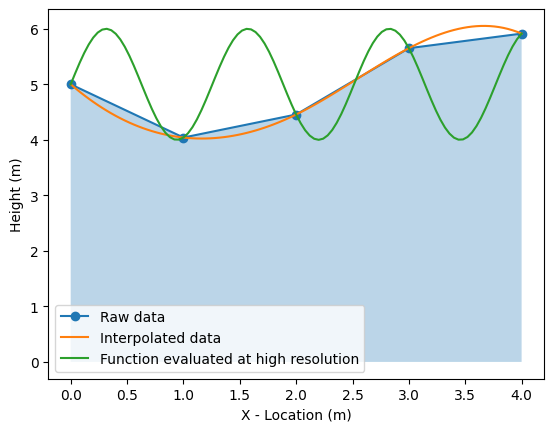

In [30]:
plt.plot(x_locations, heights, marker = 'o', label = 'Raw data')
plt.fill_between(x_locations, 0, heights, alpha = 0.3)

plt.plot(x_location_high_res, interp_height_high_res, label = 'Interpolated data')

plt.plot(x_location_high_res, func_to_integrate(x_location_high_res), label = 'Function evaluated at high resolution')

# Add labels and show the plot
plt.legend(loc = 'best')
plt.xlabel('X - Location (m)')
plt.ylabel('Height (m)')
plt.show()

## Curve fitting

Suppose we had our discrete measurements of height from the integration section but knew that this should follow the form `height(x) = a + sin(x * b)`, how can we determine the optimal `a` and `b`? The answer is to use curve fitting. We saw in the numpy document how we could fit polynomials, but what about more general functions? Well `scipy.optimize` provides the [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) method to help us with this. This requires three things:

1. The x values of the sampled data
2. The y values of the sampled data
3. A python function which given a value of `x` and any parameters of the model returns a guess for `y`, in other words a python version of the function we're trying to fit.

For the case we're considering we could do:

In [ ]:
# Plot the raw data first so we can remember what this looks like
plt.plot(x_locations, heights, marker = 'o', label = 'Raw data')
plt.fill_between(x_locations, 0, heights, alpha = 0.3)

# Define a function of the form we are trying to fit, y = a + sin(b * x)
# It takes x, a and b and returns y
def fitting_function(x, a, b):
    return a + sin(x * b)

# Get our curve fitting method
from scipy.optimize import curve_fit

# Fit the data
initial_guess = [1.0, 4.0]
fitted_parameters, covariance = curve_fit(fitting_function, x_locations, heights, p0 = initial_guess)
print('The first fit found a, b = ', fitted_parameters)

# Fit again and try a different guess
initial_guess2 = [1.0, 4.5]
fitted_parameters2, covariance2 = curve_fit(fitting_function, x_locations, heights, p0 = initial_guess2)
print('The first fit found a, b = ', fitted_parameters2)

# Plot the resulting fits
y_fit_1 = fitting_function(x_location_high_res, fitted_parameters[0], fitted_parameters[1])
y_fit_2 = fitting_function(x_location_high_res, fitted_parameters2[0], fitted_parameters2[1])

plt.plot(x, y_fit_1, label = 'Fit 1')
plt.plot(x, y_fit_2, label = 'Fit 2')

# Add labels and show the plot
plt.legend(loc = 'best')
plt.xlabel('X - Location (m)')
plt.ylabel('Height (m)')
plt.show()

Note that we have tried to fit twice and that these give quite different results. The only difference between these cases are the initial guess for the model parameters used in each case. In some problems the solution is not very sensitive to the initial guess but in others (particularly involving periodic functions like `sin`) the initial guess is very important. It's often a good idea to try fitting with different initial guesses in order to determine how robust your fit is.

We also obtain the covariance of the fitted model parameters. This can be used to provide error estimates on the fit parameters.